In [1]:
import torch 
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

from attrdict import AttrDict
import numpy as np
import random

import matplotlib.pyplot as plt

In [2]:
args = AttrDict()
args.seeds = 1111

In [3]:
random_seed = args.seeds
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [4]:
class MLP_Layer(nn.Module):
    #def __init__(self,in_dim=1,out_dim=1,hdim = 50 ):
    def __init__(self,in_dim=1,out_dim=1,hdim = 20 ):
        
        super(MLP_Layer,self).__init__()

        #self.in_dim = in_dim + 1
        self.in_dim = in_dim + 1        
        self.out_dim = out_dim
        self.hdim = hdim

        linear1 = nn.Linear(self.in_dim,self.hdim )
        linear2 = nn.Linear(self.hdim,self.hdim)
        linear3 = nn.Linear(self.hdim,self.hdim)
        linear4 = nn.Linear(self.hdim,self.out_dim)

        activation =  nn.Tanh()
        linear = [linear1,
                  activation,
                  linear2,
                  activation,
                  linear3,
                  activation,
                  linear4]
        self.mapping = nn.Sequential(*linear)
        
        def init_weights(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform(module.weight)
                module.bias.data.fill_(0.0)
                
        self.mapping.apply(init_weights)
        
                
    def forward(self,x):        
        return self.mapping(x)
    
    
    
    


class PINN_Basic(nn.Module):
    def __init__(self,nn_model, pdetype = 'v1' ):
        super(PINN_Basic,self).__init__()

        self.pde_type = pdetype
        self.nn_model = nn_model
        self.in_dim =  nn_model.in_dim         
        self.out_dim = nn_model.out_dim
        self.reg_lambda = 1
        
        #self.mse_loss = nn.MSELoss(reduce=False)
        self.mse_loss = nn.MSELoss(reduce=True,reduction = 'mean')
            
    def forward(self,xt):        
        u_xt = self.nn_model(xt)                
        return u_xt
    
    
    def compute_loss(self,xt_rd,y_rd,xt_init,u_init,xt_bd,u_bd):
        loss_rd = self.compute_pdeloss_rd(xt_rd,y_rd)
        loss_init = self.compute_pdeloss_bdinit(xt_init,u_init)
        loss_bd = self.compute_pdeloss_bdinit(xt_bd,u_bd)        
        #loss = loss_rd + self.reg_lambda*(0.5*loss_init + 0.5*loss_bd)
        #return loss_rd + self.reg_lambda*(0.5*loss_init + 0.5*loss_bd)
        return loss_rd,loss_init,loss_bd


    
    def compute_pdeloss_rd(self,xt,y):        
        xt_grad = xt.clone()
        xt_grad.requires_grad = True

        u = self.nn_model(xt_grad)                
        du_dxt= autograd.grad(u,xt_grad,torch.ones_like(u).to(u.device),retain_graph=True,create_graph=True)[0]
        du_dx_dxt = autograd.grad(du_dxt[:,:,:-1],xt_grad,torch.ones_like(du_dxt[:,:,:-1]).to(xt_grad.device),retain_graph=True,create_graph=True)[0]
        du_dx = du_dxt[:,:,:-1]
        du_dxx = du_dx_dxt[:,:,:-1]

        # compute loss depending on pde
        pde_loss = self.mse_loss(0.01*du_dxx,y)
        
        return pde_loss
    
    
    def compute_pdeloss_bdinit(self,xt,y):        
        u = self.nn_model(xt)                
        # compute loss depending on pde
        pde_loss = self.mse_loss(u,y)
        
        return pde_loss

In [5]:
def swag_parameters(module, params, no_cov_mat=True):
    for name in list(module._parameters.keys()):
        #print(name)
        if module._parameters[name] is None:
            continue
        data = module._parameters[name].data
        # turn off pop, which makes error
        #module._parameters.pop(name)
        module.register_buffer("%s_mean" % name, data.new(data.size()).zero_())
        module.register_buffer("%s_sq_mean" % name, data.new(data.size()).zero_())

        if no_cov_mat is False:
            module.register_buffer(
                "%s_cov_mat_sqrt" % name, data.new_empty((0, data.numel())).zero_()
            )

        params.append((module, name))
    return
    
    
    
#--------------------------------------------------------
# reference:
# https://github.com/wjmaddox/swa_gaussian/blob/ed5fd56e34083b42630239e59076952dee44daf4/swag/posteriors/swag.py#L237
# https://github.com/wjmaddox/swa_gaussian/blob/master/experiments/train/train.py
#--------------------------------------------------------
class PINN_SWAG(PINN_Basic):
    
    def __init__(self,nn_model, pdetype = 'v1', max_num_models = 10 ,update_period = 50, eps=1e-16):
        super(PINN_SWAG,self).__init__(nn_model, pdetype)

        # ----------------
        # swag
        # ----------------        
        self.register_buffer("n_models", torch.zeros([1], dtype=torch.long))     
        
        self.var_clamp = eps
        self.max_num_models = max_num_models
        self.no_cov_mat = False        
        self.params = list()
        self.nn_model.apply( lambda module: swag_parameters(module=module, params=self.params, no_cov_mat=self.no_cov_mat )  )        
            
            
    # %s_mean" % name
    # %s_sq_mean" % name
    # %s_cov_mat_sqrt_mean" % name
    
    def compute_preddist(self,xt,num_sample=10):        
        pred_list = []
        for _ in range(num_sample):
            self.sample()
            pred_list.append(self.forward(xt).unsqueeze(dim=-1))
        pred_list = torch.cat(pred_list,dim=-1)    
        emp_pmu = pred_list.mean(dim=-1) 
        emp_pstd = pred_list.std(dim=-1) 
        
        #return emp_pmu,emp_pstd,pred_list
        return emp_pmu,emp_pstd

    
    
    #def collect_model(self, base_model):
    def collect_model(self):        
        #for (module, name), base_param in zip(self.params, base_model.parameters()):
        for (module, name), base_param in zip(self.params, self.nn_model.parameters()):            
            mean = module.__getattr__("%s_mean" % name)
            sq_mean = module.__getattr__("%s_sq_mean" % name)

            # first moment
            mean = mean * self.n_models.item() / (
                self.n_models.item() + 1.0
            ) + base_param.data / (self.n_models.item() + 1.0)

            # second moment
            sq_mean = sq_mean * self.n_models.item() / (
                self.n_models.item() + 1.0
            ) + base_param.data ** 2 / (self.n_models.item() + 1.0)

            # square root of covariance matrix
            if self.no_cov_mat is False:
                cov_mat_sqrt = module.__getattr__("%s_cov_mat_sqrt" % name)

                # block covariance matrices, store deviation from current mean
                dev = (base_param.data - mean).view(-1, 1)
                cov_mat_sqrt = torch.cat((cov_mat_sqrt, dev.view(-1, 1).t()), dim=0)

                # remove first column if we have stored too many models
                if (self.n_models.item() + 1) > self.max_num_models:
                    cov_mat_sqrt = cov_mat_sqrt[1:, :]
                module.__setattr__("%s_cov_mat_sqrt" % name, cov_mat_sqrt)

            module.__setattr__("%s_mean" % name, mean)
            module.__setattr__("%s_sq_mean" % name, sq_mean)
        self.n_models.add_(1)    
        return 
    
    
    def sample(self, scale=1.0, cov=False, seed=None, block=False, fullrank=True):
#         if seed is not None:
#             torch.manual_seed(seed)

#         if not block:
#             self.sample_fullrank(scale, cov, fullrank)
#         else:
#             self.sample_blockwise(scale, cov, fullrank)

        self.sample_blockwise(scale, cov, fullrank)
        return


    def sample_blockwise(self, scale, cov, fullrank):
        for module, name in self.params:
            mean = module.__getattr__("%s_mean" % name)

            sq_mean = module.__getattr__("%s_sq_mean" % name)
            eps = torch.randn_like(mean)

            var = torch.clamp(sq_mean - mean ** 2, self.var_clamp)

            scaled_diag_sample = scale * torch.sqrt(var) * eps

            if cov is True:
                cov_mat_sqrt = module.__getattr__("%s_cov_mat_sqrt" % name)
                eps = cov_mat_sqrt.new_empty((cov_mat_sqrt.size(0), 1)).normal_()
                cov_sample = (
                    scale / ((self.max_num_models - 1) ** 0.5)
                ) * cov_mat_sqrt.t().matmul(eps).view_as(mean)

                if fullrank:
                    w = mean + scaled_diag_sample + cov_sample
                else:
                    w = mean + scaled_diag_sample

            else:
                w = mean + scaled_diag_sample


            #print('before (module.__getattr__(name)).data')
            #print(module.__getattr__(name).data)
            #print('after (module.__getattr__(name)).data')
            #print(module.__getattr__(name).data)       
            #print('')
    
            #---------------------------------------
            # debuggin checked, 
            # when updating the samples of parameters, it update copied module and original module (nn base model) automatically
            # we do not need to copy the item manually
            # we sample -> predict where the sampled parameters are automatically reflected on the original module (nn base model)             
            #---------------------------------------        
            
            #module.__setattr__(name, w)            
            module.__getattr__(name).data = w 
        
        return 

## target problem: 1d nonlinear Poisson equation

In [6]:
#---------------------------------
# data configuration
#---------------------------------
dataconfig = AttrDict()

dataconfig.in_dim,dataconfig.out_dim  = 1,1
#dataconfig.noisestd = .5
#dataconfig.noisestd = 0.25
#dataconfig.noisestd = 0.1
dataconfig.noisestd = 0.01

#nb,nobs = 16,16 #(nsensors=16)

dataconfig.nb,dataconfig.nobs = 8,32 #(nsensors=32)

dataconfig.xmin,dataconfig.xmax = -0.7,0.7
dataconfig.tmin,dataconfig.tmax = 0,1

dataconfig

AttrDict({'in_dim': 1, 'out_dim': 1, 'noisestd': 0.01, 'nb': 8, 'nobs': 32, 'xmin': -0.7, 'xmax': 0.7, 'tmin': 0, 'tmax': 1})

In [7]:
def gen_obs(dataconfig):
    
    u = lambda x: torch.pow(torch.sin(6*x),3)
    f = lambda x: (6**3)*torch.sin(6*x)*torch.pow(torch.cos(6*x),2) - 3*(6**2)*torch.pow(torch.sin(6*x),3)
  
    # ----------------------------
    # gen datset on rd
    # ----------------------------    
    x = dataconfig.xmin  + (dataconfig.xmax  - dataconfig.xmin)* torch.rand(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    g_noise = dataconfig.noisestd*torch.randn(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    t = (dataconfig.tmax  - dataconfig.tmin)* torch.rand(dataconfig.nb,1,1 ).repeat(1,dataconfig.nobs,1)

    f_xt = f(x)
    y_rd = 0.01*f_xt + g_noise     
    xt_rd = torch.cat([x,t],dim=-1)
    

    # ----------------------------
    # gen datset on init
    # ----------------------------    
    x = dataconfig.xmin  + (dataconfig.xmax  - dataconfig.xmin)* torch.rand(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    g_noise = dataconfig.noisestd*torch.randn(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    t = 0*torch.rand(dataconfig.nb,1,1 ).repeat(1,dataconfig.nobs,1)
    u_init = u(x)
    xt_init = torch.cat([x,t],dim=-1)

    # ----------------------------
    # gen datset on bd
    # ----------------------------    
    x = torch.cat([dataconfig.xmin* torch.ones(dataconfig.nb,dataconfig.nobs//2,dataconfig.in_dim ),
                   dataconfig.xmax* torch.ones(dataconfig.nb,dataconfig.nobs//2,dataconfig.in_dim )],dim=-2)
     
    #g_noise = dataconfig.noisestd*torch.randn(dataconfig.nb,dataconfig.nobs,dataconfig.in_dim )
    t = torch.rand(dataconfig.nb,dataconfig.nobs,1  )
    u_bd = u(x)
    #y_bd = u_bd      
    xt_bd = torch.cat([x,t],dim=-1)
        
    return (xt_rd,y_rd,f_xt),(xt_init,u_init),(xt_bd,u_bd)    


    

In [8]:
dataconfig

AttrDict({'in_dim': 1, 'out_dim': 1, 'noisestd': 0.01, 'nb': 8, 'nobs': 32, 'xmin': -0.7, 'xmax': 0.7, 'tmin': 0, 'tmax': 1})

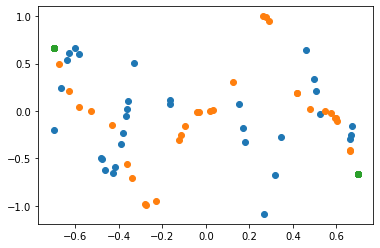

In [9]:
rd_set,init_set,bd_set = gen_obs(dataconfig)

xt_rd,y_rd,f = rd_set
xt_init,u_init = init_set
xt_bd,u_bd = bd_set

bidx = 1
plt.scatter(xt_rd[bidx,:,0].cpu().data.numpy(),y_rd[bidx,:,0].cpu().data.numpy())
plt.scatter(xt_init[bidx,:,0].cpu().data.numpy(),u_init[bidx,:,0].cpu().data.numpy())
plt.scatter(xt_bd[bidx,:,0].cpu().data.numpy(),u_bd[bidx,:,0].cpu().data.numpy())

#plt.scatter(xt_init[:,0].cpu().data.numpy(),u_init[:,0].cpu().data.numpy())
# plt.scatter(xt[:,0].cpu().data.numpy(),f[:,0].cpu().data.numpy())


In [10]:
#len(rd_set[:-1])

In [11]:
# mlp_layer = MLP_Layer(in_dim = 1, out_dim=1)
# mlp_layer
#model = PINN_Basic( MLP_Layer(in_dim = 1, out_dim=1) )
model = PINN_SWAG( MLP_Layer(in_dim = 1, out_dim=1) )

model

/home/yohan/Myenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/home/yohan/Myenv/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


PINN_SWAG(
  (nn_model): MLP_Layer(
    (mapping): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): Tanh()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Tanh()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Tanh()
      (6): Linear(in_features=20, out_features=1, bias=True)
    )
  )
  (mse_loss): MSELoss()
)

In [12]:
trainconfig = AttrDict()

trainconfig.nepochs = 2000
trainconfig.lr = 1e-3
trainconfig.weightdecay = 1e-4

trainconfig.init_rate = .5
trainconfig.start_nepochs = int(trainconfig.nepochs*trainconfig.init_rate)
trainconfig.updateperiod = 25

optimizer = torch.optim.Adam(model.parameters(), lr=trainconfig.lr,weight_decay=trainconfig.weightdecay)


In [37]:
model.train()
for j in range(1,trainconfig.nepochs+1):
    rd_set,init_set,bd_set = gen_obs(dataconfig)
    loss_rd,loss_init,loss_bd = model.compute_loss(*rd_set[:-1],*init_set,*bd_set)
    
    loss = loss_rd + 0.5*(loss_init + loss_bd) 
        
    #update model params
    optimizer.zero_grad()        
    loss.backward()
    optimizer.step()

    
    if (trainconfig.start_nepochs <= j and
       (j - trainconfig.start_nepochs) % trainconfig.updateperiod== 0
    ):
        print('update at {}'.format(j))
        model.collect_model()

        
    if j % 10 == 0:
        print('[{} /{}]: tr loss: {:.2f} \t {:.2f},{:.2f},{:.2f}'.format(j,trainconfig.nepochs,loss,loss_rd,loss_init,loss_bd))
        

[10 /2000]: tr loss: 0.54 	 0.32,0.31,0.12
[20 /2000]: tr loss: 0.54 	 0.32,0.43,0.02
[30 /2000]: tr loss: 0.59 	 0.35,0.42,0.04
[40 /2000]: tr loss: 0.55 	 0.34,0.35,0.07
[50 /2000]: tr loss: 0.51 	 0.30,0.35,0.06
[60 /2000]: tr loss: 0.55 	 0.32,0.40,0.05
[70 /2000]: tr loss: 0.55 	 0.32,0.40,0.06
[80 /2000]: tr loss: 0.54 	 0.33,0.35,0.06
[90 /2000]: tr loss: 0.50 	 0.31,0.32,0.05
[100 /2000]: tr loss: 0.50 	 0.28,0.38,0.05
[110 /2000]: tr loss: 0.56 	 0.35,0.36,0.05
[120 /2000]: tr loss: 0.50 	 0.33,0.31,0.05
[130 /2000]: tr loss: 0.54 	 0.34,0.36,0.05
[140 /2000]: tr loss: 0.49 	 0.36,0.23,0.04
[150 /2000]: tr loss: 0.50 	 0.33,0.29,0.05
[160 /2000]: tr loss: 0.49 	 0.31,0.31,0.04
[170 /2000]: tr loss: 0.50 	 0.36,0.23,0.06
[180 /2000]: tr loss: 0.49 	 0.35,0.24,0.05
[190 /2000]: tr loss: 0.49 	 0.35,0.24,0.04
[200 /2000]: tr loss: 0.47 	 0.34,0.23,0.05
[210 /2000]: tr loss: 0.45 	 0.35,0.15,0.05
[220 /2000]: tr loss: 0.43 	 0.32,0.18,0.04
[230 /2000]: tr loss: 0.41 	 0.33,0.14,0.

In [38]:
#model.collect_model(model.nn_model)

In [39]:
# %s_mean" % name
# %s_sq_mean" % name
# %s_cov_mat_sqrt_mean" % name

#__getattr__("%s_mean" % name)

#model.params

In [40]:
#model.params[0][0].__getattr__('%s_mean' % 'weight'),model.params[0][0].__getattr__('%s' % 'weight') ,  model.nn_model.mapping[0].weight

In [41]:
#model.sample()

In [42]:
#model.params[0][0].__getattr__('%s_mean' % 'weight'),model.params[0][0].__getattr__('%s' % 'weight') , model.nn_model.mapping[0].weight

In [43]:
# (tensor([[ 0.6800,  0.2006],
#          [ 0.0344, -0.5858],
#          [ 0.4905, -0.2293],
#          [-0.3644,  0.9780],
#          [ 0.3410, -0.7152],
#          [-0.8805,  0.1235],
#          [-1.0066, -0.2175],
#          [-0.5921,  0.5227],
#          [ 1.3243,  0.7722],
#          [-0.4579, -0.2471]]), Parameter containing:

## eval mode

In [44]:
model.eval()

PINN_SWAG(
  (nn_model): MLP_Layer(
    (mapping): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): Tanh()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Tanh()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Tanh()
      (6): Linear(in_features=20, out_features=1, bias=True)
    )
  )
  (mse_loss): MSELoss()
)

In [45]:
rd_set,init_set,bd_set = gen_obs(dataconfig)

xt_rd,y_rd,f = rd_set
xt_init,u_init = init_set
xt_bd,u_bd = bd_set

In [47]:
pred_mu,pred_std = model.compute_preddist(xt_rd,num_sample=20)


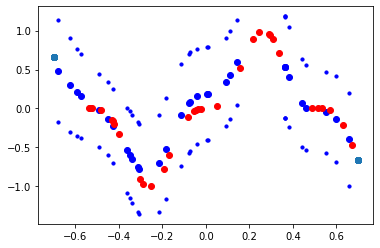

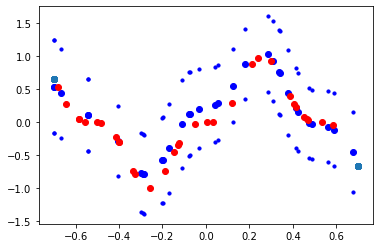

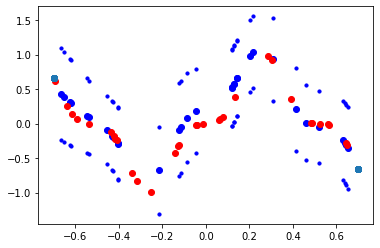

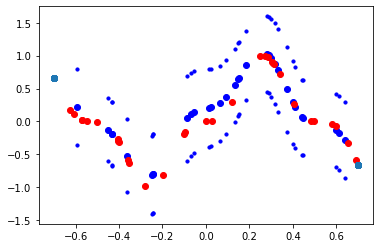

In [48]:
#for x_rd,y_rd,u_rd in xt_rd,u:
#figure()
for j in range(4):
    #model.sample()
    #uxt_rd = model(xt_rd)

    fig = plt.figure()
    #plt.scatter(xt_rd[j,:,0].cpu().data.numpy(),uxt_rd[j,:,0].cpu().data.numpy(),color='b')
    plt.scatter(xt_rd[j,:,0].cpu().data.numpy(),pred_mu[j,:,0].cpu().data.numpy(),color='b')
    plt.scatter(xt_rd[j,:,0].cpu().data.numpy(),(pred_mu-2*pred_std)[j,:,0].cpu().data.numpy(),s=10,color='b')
    plt.scatter(xt_rd[j,:,0].cpu().data.numpy(),(pred_mu+2*pred_std)[j,:,0].cpu().data.numpy(),s=10,color='b')
    
    plt.scatter(xt_init[j,:,0].cpu().data.numpy(),u_init[j,:,0].cpu().data.numpy(),color='r')
    plt.scatter(xt_bd[j,:,0].cpu().data.numpy(),u_bd[j,:,0].cpu().data.numpy())
    
    plt.show()
    
    
#plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),f[0,:,0].cpu().data.numpy(),zorder=2)
#plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())

    
# for x_rd,y_rd,u_rd in xt_rd,u:
#     figure()
#     plt.scatter(xt_rd[0,:,0].cpu().data.numpy(),uxt_rd[1,:,0].cpu().data.numpy())
#     plt.scatter(xt_rd[1,:,0].cpu().data.numpy(),rd_set[2][1,:,0].cpu().data.numpy())


In [86]:
#rd_set